# Download Data

In [ ]:
# !pip install kaggle

In [ ]:
# !mkdir ~/.kaggle
# !touch ~/.kaggle/kaggle.json

# api_token = {"username":"samih2141","key":"ab01bc279468e400c75af864a35c12df"}

# import json

# with open('/root/.kaggle/kaggle.json', 'w') as file:
#     json.dump(api_token, file)

# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d saurabhshahane/fake-news-classification # clmentbisaillon/fake-and-real-news-dataset

In [ ]:
# import shutil
# filename = "fake-news-classification.zip" # "/content/fake-and-real-news-dataset.zip"
# shutil.unpack_archive(filename, "/content")

In [ ]:
# df = pd.read_csv('WELFake_Dataset.csv')

# Preprocessing

## *Loading*

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data_dir = "drive/MyDrive/ECS 271 Project/"
df = pd.read_csv(data_dir + "WELFake_Dataset.csv")

## *Exploratory Data Analysis*

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [ ]:
df.dropna(inplace=True)

## *Vectorizing*

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import EnglishStemmer

In [ ]:
stemmer = EnglishStemmer()
analyzer = CountVectorizer().build_analyzer()
def stemmed_words(doc):
  return(stemmer.stem(w) for w in analyzer(doc))
vectorizer = CountVectorizer(analyzer=stemmed_words)

In [ ]:
X = vectorizer.fit_transform(df["title"])
Y = df["label"]

## *Modelling*

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
# normally the test size is 0.3 but logistic regression does not converge at that rate
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
clf = LogisticRegression().fit(X_train, Y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
Y_pred = clf.predict(X_test)
acc = sum(Y_pred == Y_test)/len(Y_test)
print("Accuracy: {:.2f}%".format(acc * 100)) # really bad for LIAR lol
# 30-70 accuracy: 95.06
# 60-40 accuracy: 95.96

Accuracy: 90.04%


In [ ]:
# clf.__dict__                        # attributes/methods of the classifier
# vectorizer.get_feature_names_out()  # detected words
# clf.coef_                           # matrix of coefficients for each word for each class (num classes x num words)

# Generating Adversarial Data

## Detecting Keywords

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

In [ ]:
words = vectorizer.get_feature_names_out()

In [ ]:
n = 2000 # top n words
# print ("{:<15} {:<55} {:<55}".format('Class','Positive Indicator', 'Negative Indicator'))
for i in range(len(clf.coef_)): # only one iteration for binary classification
  coefs = clf.coef_[i]
  sorted_inds = coefs.argsort()
  keywords_fake = [words[j] for j in sorted_inds[-n:]]
  keywords_true = [words[j] for j in sorted_inds[:n]]
  # print ("{:<15} {:<55} {:<55}".format(clf.classes_[i], str(words_pos), str(words_neg)))

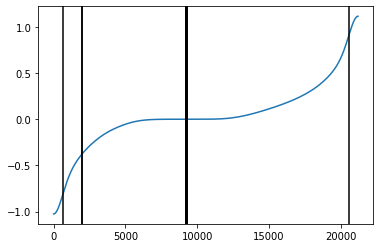

In [ ]:
# get all coefficients
sorted_coefs = [coefs[j] for j in sorted_inds]
smoothed_coefs = gaussian_filter1d(sorted_coefs, 500)

# compute second derivative
deriv2 = np.gradient(np.gradient(smoothed_coefs))

# find inflection points
inflections = np.where(np.diff(np.sign(deriv2)))[0]

# plot coefficients and inflection points
plt.plot(smoothed_coefs)
for point in inflections:
    plt.axvline(point, color='k')

In [ ]:
inflections # around 2000 keywords should work

array([  638,  1996,  1999,  9245,  9248,  9254,  9257,  9262,  9263,
        9268, 20561])

In [ ]:
print(keywords_fake[-10:])

['mosul', 'imag', 'humili', 'bombshel', 'hilari', 'break', 'aleppo', 'wow', 'boiler', 'video']


In [ ]:
print(keywords_true[:10])

['breitbart', 'york', 'factbox', 'polar', 'myanmar', 'catalan', '202', 'rohingya', 'zimbabw', 'singapor']


## Fudging Functions

In [ ]:
def wordFudger(word):
  fudge = chr(np.random.randint(97,122))
  return fudge + word[1:]

In [ ]:
def advRandomFudge(sentence,min_len=4,num_fudge=3):
  split = sentence.split()
  length = len(split)
  fudge_ids = []
  x = 0
  while len(fudge_ids) < num_fudge and x < num_fudge * 5:
    i = np.random.randint(length)
    if len(split[i]) >= min_len and i not in fudge_ids:
      fudge_ids.append(i)
    x+=1
  for i in fudge_ids:
    split[i] = wordFudger(split[i])
  return ' '.join(split)

In [ ]:
def advKeyFudge(sentence,keywords,num_fudge=-1):
  original_sentence = sentence
  num_fudge = min(num_fudge,len(keywords))
  if num_fudge == -1:
    for word in keywords:
      sentence=sentence.replace(word,wordFudger(word))
  else:
    keywords_rand = np.random.choice(keywords,num_fudge,replace=False)
    for word in keywords_rand:
      sentence=sentence.replace(word,wordFudger(word))
  if sentence == original_sentence:
    return np.nan
  else:
    return sentence

In [ ]:
def advKeyAdd(sentence, keywords, num_add=1):
  num_add = min(num_add, len(keywords))
  return sentence + " " + ' '.join(np.random.choice(keywords, num_add, replace=False))

## Generating Data

In [ ]:
from google.colab import files

In [ ]:
advSetRandom = df.copy()
advSetKey = df.copy()
advSetAppend = df[df["label"] == 0].copy()

# fudge random words for all samples
advSetRandom['title'] = df.apply((lambda x: advRandomFudge(x.title)), axis=1)
# fudge fake keywords for fake samples and true keywords for true samples
advSetKey['title'] = df.apply((lambda x: advKeyFudge(x.title, keywords_fake, num_fudge=-1) \
                               if x.label == 0 else advKeyFudge(x.title, keywords_true, num_fudge=1)), axis=1)
# append true keywords to fake samples
advSetAppend['title'] = advSetAppend['title'].apply(lambda x: advKeyAdd(x, keywords_true, num_add=1))

advSetRandom.dropna(inplace=True)
advSetKey.dropna(inplace=True)
advSetAppend.dropna(inplace=True)

advSetRandom.to_csv('advDataRandom.csv')
advSetKey.to_csv('advDataKey.csv')
advSetAppend.to_csv('advDataAppend.csv')

In [ ]:
print(len(df), len(advSetRandom), len(advSetKey), len(advSetAppend))

71537 71537 35059 35028


In [ ]:
files.download('advDataRandom.csv')
files.download('advDataKey.csv')
files.download('advDataAppend.csv')

In [ ]:
# fudge 3 words instead of 1:
advSetRandom = df.copy()
advSetRandom['title'] = df.apply((lambda x: advRandomFudge(x.title)), axis=1)
advSetRandom.dropna(inplace=True)
advSetRandom.to_csv('advDataRandom-2.csv')
files.download('advDataRandom-2.csv')